In [3]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce

import pose_2D as pose2d
import pose_3D as pose3d
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
import time, sys
from IPython.display import clear_output

def update_progress(progress,  message):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    for m in message:
        print(m)

In [5]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

In [6]:
torch.cuda.is_available()

True

In [7]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.current_device()

0

In [9]:
!nvidia-smi

Fri Nov 22 10:03:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0  On |                  N/A |
| 31%   56C    P2    65W / 250W |   4794MiB / 11016MiB |     21%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   41C    P8     9W / 257W |   4943MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## 1- Load

In [10]:
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

#### code for generating the original pose from proportions

base_3dpose_data = []
for i, ind in enumerate(data_set_props):
    if not i%1000:
        update_progress(i/len(data_set_props),['hey'])
    body_prop = dict(zip(list_body, [ind[0],ind[1],ind[2],ind[3],ind[4],ind[5],ind[6],ind[7]]))
    face_pos = dict(zip(list_face, [[ind[8],ind[9],ind[10]],[ind[11],ind[12],ind[13]],[ind[14],ind[15],ind[16]]]))
    base_3dpose_data.append(pose2d.generate_3D_model(body_prop, face_pos).reshape((21,3)).transpose())

pkl.dump((np.array(data_set_3d), np.array(data_set_2d), np.array(data_set_angles), np.array(data_set_props),\
          np.array(data_depths), np.array(base_3dpose_data)), open( "data/DATASETv_4.pkl", "wb" ))

In [12]:
data_set_3d, data_set_2d, data_set_angles, data_set_props,data_depths, base_3dpose_data = \
                                                                        pkl.load(open("data/DATASETv_5.pkl", "rb"))

In [13]:
print(data_set_2d.shape)
print(data_set_props.shape)
print(data_depths.shape)
print(data_set_angles.shape)
print(base_3dpose_data.shape)

(3044253, 42)
(3044253, 17)
(3044253,)
(3044253, 17)
(3044253, 3, 21)


In [14]:
data_depths = data_depths.reshape(len(data_depths), 1)
inputs = np.concatenate((data_set_2d, data_set_props), axis=1)
labels = np.concatenate((data_set_angles, data_depths), axis=1)

In [15]:
labels.shape

(3044253, 18)

In [ ]:
i=800
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16) = data_set_angles[i]
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
test0 = pose3d.full_pose_rotation(base_3dpose_data[i], angle_dic).transpose().flatten()
go.Figure(vs.plot([test0, data_set_3d[i]]))

### b- Sample the large data

In [16]:
sample_size = 1000000
sample_inputs, sample_labels, sample_base_3dpose = zip(*rand.sample(list(zip(inputs, labels, base_3dpose_data)),
                                                                    sample_size))

In [17]:
train_inputs = np.array(list(sample_inputs[:int(0.8*sample_size)]))
train_labels = np.array(list(sample_labels[:int(0.8*sample_size)]))
train_base_3dpose = np.array(list(sample_base_3dpose[:int(0.8*sample_size)]))
val_inputs = np.array(list(sample_inputs[int(0.8*sample_size):]))
val_labels = np.array(list(sample_labels[int(0.8*sample_size):]))
val_base_3dpose = np.array(list(sample_base_3dpose[int(0.8*sample_size):]))

In [18]:
val_labels.shape

(200000, 18)

### c- add random input occlusion

In [19]:
def add_occlusion(pedestrian):
    dim = int(pedestrian.shape[0]/14)
    pedestrian = pedestrian.reshape((14,dim)).transpose()
    states = [ 'left wrist occluded', 'right wrist occluded', ]

## 2- create and prepare model

In [20]:
net = mlmodel.LinearModel(59, 18, num_stage=3)

In [21]:
net = net.to(device)

### a- prepare data loader and learning rate decay

In [22]:
class PrepareData(Dataset):
    def __init__(self, X, Y, BasePose):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()

        if not torch.is_tensor(Y):
            self.Y = torch.from_numpy(Y).float()
            
        if not torch.is_tensor(BasePose):
            self.BasePose = torch.from_numpy(BasePose).float()
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.BasePose[idx]

In [23]:
loss = nn.MSELoss()
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.8
    epochs_drop = 60.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate

In [24]:
size_batches = 600
ds = PrepareData(X=train_inputs, Y=train_labels, BasePose=train_base_3dpose)

ds = DataLoader(ds, batch_size = size_batches, shuffle=True)



In [25]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv

In [26]:
def project_pose_2cam(pose, kk, z_shift, joints2keep):
    
    pose_moved = pose.copy()
    pose_moved[2] += z_shift
    projected_pose = []
    
    for point in pose_moved.transpose():
        projected_pose.append(list(project_to_pixels(point, kk)))
    
    projected_pose = np.array(projected_pose).transpose()
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, 0)
    projected_pose = pose2d.normalize(projected_pose)
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, -10).transpose().flatten()
    
    return projected_pose

In [27]:
def project_to_pixels(all_points, kk):
    """Project a single point in space into the image"""
    
    mat = [kk for _ in all_points]
    
    xx, yy, zz = torch.dot(kk, xyz)
    uu = xx / zz
    vv = yy / zz

    return uu, vv

# on test des trucs la

In [35]:
limbs = [(17,20),(17,1),(1,2),(2,3),(17,4),(4,5),(5,6),(7,8),(8,9),(10,11),(11,12),(7,10),(17,19),(19,18)]
joints = list(range(21))

limb_names = ["neck", "right shoulder", "right biceps", "right forearm", "left shoulder", "left biceps",
              "left forearm", "right quad", "right tibias", "left quad", "left tibias","hip", "upper back", "lower back"]

joint_names = ['nose', 'right shoulder','right elbow', 'right wrist', 'left shoulder', 'left elbow', 'left wrist', 
               'right hip', 'right knee', 'right ankle', 'left hip', 'left knee', 'left ankle','right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head']

limb_dict = dict(zip(limb_names, limbs))
joint_dict = dict(zip(joint_names, joints))

joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']
#joints2keep = [joint_dict[x] for x in joints2keep]


In [36]:
joint_dict['left hip']

10

In [ ]:
def full_pose_rotation(data, angle_dic):
    
    members = ['right arm', 'left arm', 'right leg', 'left leg']
    head_or_back = ['head','back']
    axis = ['x', 'y', 'z']
    
    final_pose = data
    
    for key in angle_dic.keys():
        a = angle_dic[key]
        if key in members:
            final_pose = move_member(final_pose, key, a[0], a[1], a[2], a[3])
        if key in head_or_back:
            final_pose = rotate_backOrHead(final_pose, key, a[0], a[1], a[2])
        if key in axis:
            final_pose = rotate_pose(final_pose, key, a[0])
    return final_pose

In [37]:
def tensor_normalize(list_of_poses, shift=None, resize=True):
    #we find the shift to center around the hip
    batch_size = list_of_poses.size()[0]
    
    nb_joints = list_of_poses.size()[2]
    
    if shift is None:
        shift = (list_of_poses[:,:,joint_dict['right hip']] + list_of_poses[:,:,joint_dict['left hip']])\
                .reshape((batch_size,2,1))/2

    ratio = 1
   
    if resize:
        #we find the ratio to scale down
        ratio = (torch.max(list_of_poses[:,1,:],1).values-torch.min(list_of_poses[:,1,:],1).values)
        #ratio = find_limb_length(data, 'hip')/0.1739
    ratio = torch.stack([ratio.reshape((batch_size,1)) for _ in range(list_of_poses.size()[2])], dim=2)
    # we center and scale the joints
    
    list_of_poses = (list_of_poses[:,:,:]-shift)
    
    list_of_poses = list_of_poses/ratio

    return list_of_poses

In [38]:
def tensor_project_pose_2cam(list_of_poses, kk, z_shifts, joints2keep):
    
    batch_size = list_of_poses.size()[0]
    
    nb_joints = list_of_poses.size()[2]

    mats = np.array([kk for _ in range(batch_size)]).reshape((batch_size,3,3))
    mats = torch.from_numpy(mats).float().to(device)
    
    z_shifts = torch.stack([z_shifts for _ in range(nb_joints)], dim=1)

    list_of_poses[:,2] = list_of_poses[:,2]+z_shifts
    
    kk_multiplications = torch.matmul(mats, list_of_poses)
    projected_poses = kk_multiplications/kk_multiplications.transpose(0,1)[2].reshape((batch_size,1,21))
    
    projected_poses = projected_poses[:,:2].int().float()

    
    shift = (projected_poses[:,:,joint_dict['right hip']] + projected_poses[:,:,joint_dict['left hip']])\
                .reshape((batch_size,2,1))/2
    
    joints_ids = [pose2d.joint_dict[x] for x in joints2keep]

    projected_poses[:,:,joints_ids]= tensor_normalize(projected_poses[:,:,joints_ids], shift=shift)
    
    legs_ids = [x for x in range(nb_joints) if x not in joints_ids]
    
    projected_poses[:,:,legs_ids] = -10
    #print(projected_poses)
    
    return projected_poses

#### define the data we try on

In [270]:
"""intrinsic camera matrix"""
kk = np.array([[424.72847911,  -0.46074429, 291.65605788],
               [  0.        , 426.16973617, 146.18885257],
               [  0.        ,   0.        ,   1.        ]])

list_of_poses = np.array([x.transpose().flatten() for x in base_3dpose_data[900:950]])
list_of_angles = torch.from_numpy(data_set_angles[900:950]).float().to(device)
z_shifts = data_depths[900:950]
z_shifts = torch.from_numpy(z_shifts.reshape((len(z_shifts,)))).float().to(device)

list_of_poses = torch.from_numpy(list_of_poses).float().to(device).reshape((50,21,3)).transpose(1,2)#.transpose(2,1)
list_of_poses[0].cpu().detach().numpy()

array([[ 0.        , -0.21784791, -0.21784791, -0.21784791,  0.21784791,
         0.21784791,  0.21784791, -0.10656582, -0.10656582, -0.10656582,
         0.10656582,  0.10656582,  0.10656582, -0.02837208,  0.02837208,
        -0.07895347,  0.07895347,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.9572942 , -0.6963643 , -0.38704157, -0.11336072, -0.6963643 ,
        -0.38704157, -0.11336072,  0.        ,  0.37565735,  0.72884357,
         0.        ,  0.37565735,  0.72884357, -0.9939231 , -0.9939231 ,
        -0.9572942 , -0.9572942 , -0.82682925,  0.        , -0.34818214,
        -0.9572942 ],
       [ 0.11852451,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.059683  ,  0.059683  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

#### we apply full body rotation

In [271]:
def tensor_find_limb_length(keypoints, limb_name):
    batch_size = keypoints.size()[0]
    
    return torch.norm(keypoints[:,:,limb_dict[limb_name][0]]-keypoints[:,:,limb_dict[limb_name][1]], dim=1)\
                      .reshape((batch_size,1))

""" get the position of a joint in 3d"""
def tensor_get_3d_joint_pos(keypoints, joint_name):
    batch_size = keypoints.size()[0]
    return keypoints[:,:, joint_dict[joint_name]].reshape((batch_size,3,1))

def tensor_change_3d_joint_pos(keypoints, joint_name, pos_3d):
    keypoints[:, :, joint_dict[joint_name]] = pos_3d
    return keypoints

"""Rotate the point according to an axis and an angle"""    
def tensor_rotate_point(point, rot_axis, angle):
    
    ux, uy, uz = rot_axis
    
    c = math.cos(angle)
    s = math.sin(angle)
    
    rot_matrix = np.array([[   c+ux**2*(1-c), ux*uy*(1-c)-uz*s, ux*uz*(1-c)+uy*s],
                           [uy*ux*(1-c)+uz*s,    c+uy**2*(1-c), uy*uz*(1-c)-ux*s],
                           [uz*ux*(1-c)-uy*s, uz*uy*(1-c)+ux*s,    c+uz**2*(1-c)]])
    
    return np.dot(rot_matrix, point)

In [272]:
""" Forward kinematics function"""  
def tensor_move_member(data, member_name, a0, a1, a2, a3):
    
    batch_size = data.size()[0]
    
    #### get all the useful sin and cos
    c0 = torch.cos(a0)
    c1 = torch.cos(a1)
    c2 = torch.cos(a2)
    c3 = torch.cos(a3)
    c23 = torch.cos(a2+a3)

    s0 = torch.sin(a0)
    s1 = torch.sin(a1)
    s2 = torch.sin(a2)
    s3 = torch.sin(a3)
    s23 = torch.sin(a2+a3)

    #### get what member we are moving and w
    body_side = member_name.split(maxsplit=1)[0]
    member = member_name.split(maxsplit=1)[1]

    #### define the correct limbs joints and rotation matrices
    if member == 'arm':
        member_limbs = ['biceps', 'forearm']
        member_joints = ['shoulder', 'elbow', 'wrist']
        
        r_1 = []
        r_2 = []
        for i in range(batch_size):

            r_2.append(torch.tensor([[1,       0,      0],
                                     [0,   c0[i], -s0[i]],
                                     [0,   s0[i],  c0[i]]]))


            r_1.append(torch.tensor([[ c1[i],  0,   s1[i]],
                                     [     0,  1,       0],
                                     [-s1[i],  0,    c1[i]]]))
        
    else:
        member_limbs = ['quad', 'tibias']
        member_joints = ['hip', 'knee', 'ankle']

        r_2.append(torch.tensor([[ c0[i],     0, s0[i]],
                                 [     0,     1,     0],
                                 [-s0[i],     0, c0[i]]]))

        r_1.append(torch.tensor([[ c1[i], -s1[i],    0],
                                 [ s1[i],  c1[i],    0],
                                 [     0,      0,    1]]))
        
    r_1 = torch.stack(r_1, dim=0).to(device)
    r_2 = torch.stack(r_2, dim=0).to(device)

    #### get the limbs lengths
    l2 = tensor_find_limb_length(data, body_side+' '+member_limbs[0])
    l3 = tensor_find_limb_length(data, body_side+' '+member_limbs[1])

    #### get the member origin
    origin_pos = tensor_get_3d_joint_pos(data, body_side+' '+member_joints[0])
    
    c2 = c2.reshape((batch_size,1))
    s2 = s2.reshape((batch_size,1))
    c23 = c23.reshape((batch_size,1))
    s23 = s23.reshape((batch_size,1))
    
    zeros = torch.tensor([0 for _ in range(batch_size)]).float().reshape((batch_size,1)).to(device)
    
    ### find the 2d positions of all the joints relative to the origin
    if member == 'arm':            
        factor = 1         
        if body_side == 'right':
            factor = -1

        x_joints = dict(zip(member_joints, [zeros, factor*(l2*c2), factor*(l2*c2 + l3*c23)]))
        y_joints = dict(zip(member_joints, [zeros, factor*(l2*s2), factor*(l2*s2 + l3*s23)]))
        z_joints = dict(zip(member_joints, [zeros, zeros, zeros]))
    else:
        y_joints = dict(zip(member_joints, [zeros, l2*c2, l2*c2 + l3*c23]))
        z_joints = dict(zip(member_joints, [zeros, l2*s2, l2*s2 + l3*s23]))
        x_joints = dict(zip(member_joints, [zeros, zeros, zeros]))
        

    #### find the new position of each joints and move it
    for joint in member_joints[1:]:
        pos = torch.stack([x_joints[joint], y_joints[joint], z_joints[joint]]).transpose(0,1)
        pos = torch.matmul(r_2,torch.matmul(r_1, pos))
        
        pos = pos + origin_pos
        
        data = tensor_change_3d_joint_pos(data, body_side+' '+joint, pos.reshape((batch_size,3)))
    
    return data

In [279]:
"""Rotate the back or head according to 3 angles"""
def rotate_backOrHead(data, member_name, a0, a1, a2):
        
        
        joints2move = {'head': ['nose','head','right eye','left eye','right ear','left ear'],
                       'back': ['nose','head','right eye','left eye','right ear','left ear',
                                'right shoulder','right elbow', 'right wrist', 'left shoulder',
                                'left elbow', 'left wrist','center shoulder']}
        origins = {'head': 'center shoulder',
                   'back': 'center back'}
        
        x = np.array([1,0,0])
        y = np.array([0,1,0])
        z = np.array([0,0,1])
        
        
        for joint in joints2move[member_name]:
            
            origin_joint = tensor_get_3d_joint_pos(data, origins[member_name])
            
            pos = tensor_get_3d_joint_pos(data, joint) - origin_joint
            
            pos = tensor_rotate_point(pos, x, a0) + origin_joint
            
            #joints_data = change_3d_joint_pos(joints_data, joint, pos.reshape((3)))
        
        y = rotate_point(y, x, a0)
        z = rotate_point(z, x, a0)
        
        for joint in joints2move[member_name]:
            pos = get_3d_joint_pos(joints_data, joint) - get_3d_joint_pos(joints_data, origins[member_name])
            
            pos = rotate_point(pos, y, a1) + get_3d_joint_pos(joints_data, origins[member_name])
            
            joints_data = change_3d_joint_pos(joints_data, joint, pos.reshape((3)))
        
        z = rotate_point(z, y, a1)
        
        for joint in joints2move[member_name]:
            pos = get_3d_joint_pos(joints_data, joint) - get_3d_joint_pos(joints_data, origins[member_name])
            
            pos = rotate_point(pos, z, a2) + get_3d_joint_pos(joints_data, origins[member_name])
            
            joints_data = change_3d_joint_pos(joints_data, joint, pos.reshape((3)))
            
        return joints_data

In [280]:
"""Rotates a pose according to angles in a dictionary"""
def tensor_full_pose_rotation(data, angle_dic):
    
    members = ['right arm', 'left arm', 'right leg', 'left leg']
    head_or_back = ['head','back']
    axis = ['x', 'y', 'z']
    
    final_pose = data
    
    for key in angle_dic.keys():
        a = angle_dic[key]
        if key in members:
            final_pose = tensor_move_member(final_pose, key, a[:,0], a[:,1], a[:,2], a[:,3])
        if key in head_or_back:
            final_pose = rotate_backOrHead(final_pose, key, a[:,0], a[:,1], a[:,2])
        #if key in axis:
         #   final_pose = rotate_pose(final_pose, key, a[0])
    return final_pose


In [281]:
# we start with creating the angle dicts
i = 8
batch_size = list_of_angles.size()[0]

angle_dic = {'head':list_of_angles[:,:3], 'back':list_of_angles[:,3:6],
             'x':list_of_angles[:,6].reshape((batch_size,1)),
             'y':list_of_angles[:,7].reshape((batch_size,1)),
             'z':list_of_angles[:,8].reshape((batch_size,1)),
             'left arm':list_of_angles[:,9:13],'right arm':list_of_angles[:,13:]}
test = tensor_full_pose_rotation(list_of_poses, angle_dic)[i].cpu().detach().numpy().transpose().flatten()
#go.Figure(vs.plot([data_set_3d[900+i], test],upper_bod_co))

torch.Size([50, 3, 1])
torch.Size([50, 3, 1])


In [263]:
list_of_poses = tensor_project_pose_2cam(list_of_poses, kk, z_shifts, joints2keep)

In [264]:
upper_bod_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(20,17),(1,4),(1,2),(2,3),(4,5),(5,6),(17,19),
                    (19,18),(18,7),(18,10)]
test = list_of_poses[i].cpu().detach().numpy().transpose().flatten()
go.Figure(vs.plot([test, data_set_2d[900+i]],upper_bod_co))

In [281]:
[list_of_poses[0].cpu().detach().numpy()]

[array([[  0.10474204,   0.02546046,  -0.02382788,   0.02902718,
           0.05626158,   0.05613086,  -0.12175795,   0.01072228,
         -10.        , -10.        ,  -0.0107223 , -10.        ,
         -10.        ,   0.09936836,  -0.11527321,   0.05896025,
           0.06794141,   0.19140902,  -0.09122378,   0.08099305,
           0.09201982],
        [ -0.29104188,  -0.26619002,   0.2839395 ,   0.65815824,
          -0.3298654 ,  -0.28920564,  -0.3418418 ,   0.09202613,
         -10.        , -10.        ,  -0.09202613, -10.        ,
         -10.        ,   0.06269673,  -0.17253591,   0.06941677,
           0.13945964,   0.0576414 ,   0.6083763 ,   0.14684872,
           0.12413213]], dtype=float32)]

# on a fini

### b- infer data and find error between ground truth and prediction

In [142]:
def infer(inputs, model):
    with torch.no_grad():
        net = model
        net = net.to(device)
        net.eval()
        inputs = torch.from_numpy(inputs).float().to(device)
        outputs = net(inputs)
        outputs.cpu().detach().numpy()
    return outputs

In [143]:
def find_error(inputs, gt, model):
    pred = infer(inputs, model).cpu().numpy()
    return np.mean(np.linalg.norm(gt-pred, axis = 1))

## 3- Train

In [144]:
losses = []
message = []
t_losses = []
v_losses = []
for epoch in range(250):
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    e_loss = []
    for i, data in enumerate(ds, 0):
        update_progress(i/len(ds),  message)
        batch_inputs, batch_labels, batch_poses = data
        (batch_inputs, batch_labels, batch_poses) = (batch_inputs.to(device), batch_labels.to(device),\
                                                     batch_poses.to(device))
        
        optimizer.zero_grad()
        
        batch_outputs = net(batch_inputs)
        
        #print(batch_poses.size())
        
        l1 = loss(batch_outputs, batch_labels)
        
        #batch_moved_poses = move_all_poses(batch_poses,batch_outputs)
        
        #projections = project_pose_2cam(batch_moved_poses, kk, z_shift, joints2keep)
        
        #l2 = loss(projections, batch_inputs)
        
        
        l1.backward()
        optimizer.step()
        
        e_loss.append(l1.cpu().detach().numpy())
    
    t_loss = find_error(train_inputs[:3000],train_labels[:3000], net)
    v_loss = find_error(val_inputs[:3000],val_labels[:3000], net)
    message.append(str(epoch)+' train loss: '+ str(t_loss)+'\t val loss: '+str(v_loss))
    t_losses.append(t_loss)
    v_losses.append(v_loss)
        
        

Progress: [#############-------] 64.8%
0 train loss: 2.3534705255403567	 val loss: 2.3581720393499963
1 train loss: 1.7961466222197129	 val loss: 1.7879090532688946
2 train loss: 1.7041240650406047	 val loss: 1.700358848055055
3 train loss: 1.7615929046384189	 val loss: 1.7611497935757727
4 train loss: 1.5633031201250263	 val loss: 1.5566944856866312
5 train loss: 1.5329599168155994	 val loss: 1.5343776642327958
6 train loss: 1.5052020954418157	 val loss: 1.5077271619829222
7 train loss: 1.4797003005437013	 val loss: 1.4787414427974133
8 train loss: 1.4659367569226167	 val loss: 1.4644946667202312
9 train loss: 1.4476757982793418	 val loss: 1.4537807750455887
10 train loss: 1.4229532555649276	 val loss: 1.4324105110741063
11 train loss: 1.4352270236704838	 val loss: 1.441787865631884
12 train loss: 1.4159444712178617	 val loss: 1.4224054051206485
13 train loss: 1.4048575609757241	 val loss: 1.413356540245499
14 train loss: 1.401893640901131	 val loss: 1.4199908536642536
15 train loss: 

KeyboardInterrupt: 

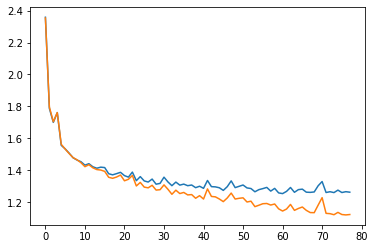

In [372]:
import matplotlib.pyplot as plt
plt.plot(np.array(v_losses[:150]))
plt.plot(np.array(t_losses[:150]))

In [145]:
#'train loss:', find_error(train_inputs,train_labels, net),
'\t val loss:', find_error(val_inputs,val_labels, net)

('\t val loss:', 1.2734773641074806)

In [146]:
name = 'net-v0_5.pkl'
torch.save(net.state_dict(), name)

In [164]:
params = torch.load('net-v0_5.pkl')
net.load_state_dict(params)

<All keys matched successfully>

#### distance error

In [147]:
errors = []
for i in range(1000):
    test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
    gt = val_labels[i]
    errors.append(abs(test[-1]-gt[-1]))
print(np.mean(errors))

0.07812381703943046


In [148]:
find_error(val_inputs,val_labels, net)

1.2734773641074806

## 4- visualize a validation result

In [149]:
i = 600
test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
gt = val_labels[i]
print(test)
print(gt)

[-0.627215   -0.94800884 -0.68062013 -0.7955515  -1.0232556   0.20964122
  0.71724045  0.0540516   0.14050278  0.64431244  0.3579499  -1.0548335
  0.28319827 -1.3404708   0.09436266  0.37491834 -0.71031517  0.577356  ]
[-0.43675586 -1.03600528 -0.5151545  -0.50953836 -1.04473734  0.17564663
  0.52537799  0.03968077  0.16465075  0.24943223  1.2246823  -1.09422324
  0.23121975 -0.47792444  0.56115423  0.30669233 -1.71101014  0.56288677]


In [150]:
props = inputs[i][42:]
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

In [151]:
body_props = dict(zip(list_body, props[:8]))
face_pos = dict(zip(list_face, props[8:].reshape((3,3))))

In [152]:
base_3d_pose = pose2d.generate_3D_model(body_props, face_pos)

In [153]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_gt) = gt
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
gt_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [154]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [284]:
upper_bod_co = [(0,20),(1, 2),(2, 3),(17, 20),(17,1),(17, 4),(17, 19),(19, 18),(4, 5),(5, 6),(0,13),(0,14),(13,15),(14,16),
            (18,7),(18,10)]
#go.Figure(vs.plot([inputs[i][:42]], torso_co))

In [156]:
d_gt, d_pred

(0.5628867718167552, 0.577356)

In [157]:
go.Figure(vs.plot([np.array([x if x>-9 else 0 for x in val_inputs[i][:42]])]), upper_bod_co)

In [159]:
go.Figure(vs.plot([gt_pose, pred_pose]))

## 5- Trying on real people

#### a- get the body proportions of the actors

run pifpaf on some calibation images

In [64]:
! python3 -m openpifpaf.predict ./data/pifpaf/proportions_images/*  --force-complete-pose -o ./data/pifpaf/proportions_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [160]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/proportions_jsons/')

we loaded 24 pedestrians


we have 2 actors in our testing

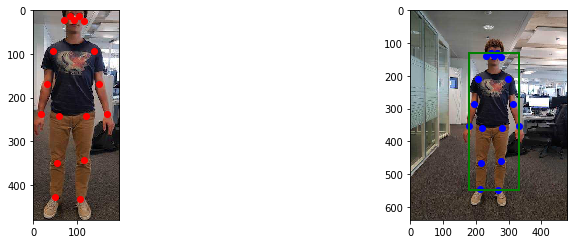

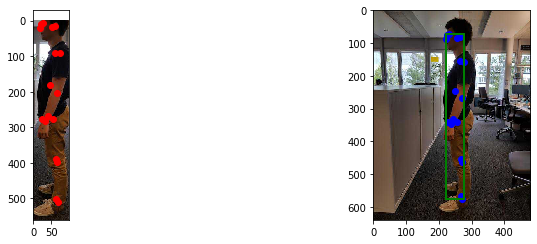

In [161]:
i=0
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [162]:
body_props_1, face_pos_1 = pose2d.get_proportions(front_view, side_view)

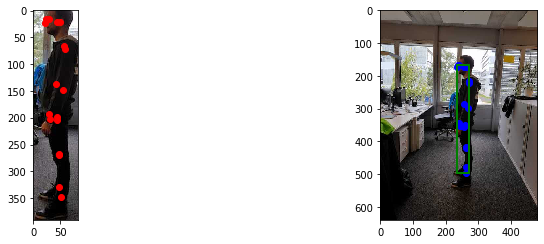

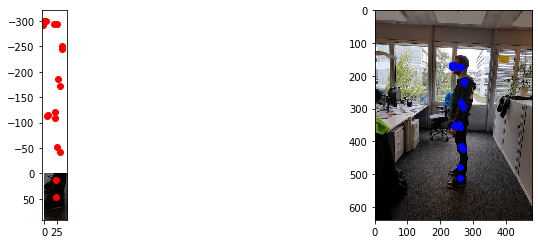

In [163]:
i=14
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [164]:
body_props_2, face_pos_2 = pose2d.get_proportions(front_view, side_view)

#### b- run the network on testing images

run pifpaf

In [165]:
! python3 -m openpifpaf.predict ./data/pifpaf/test_images/*  --force-complete-pose -o ./data/pifpaf/test_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [166]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/test_jsons/')

we loaded 15 pedestrians


In [167]:
pifpaf = [x for x in pifpaf if np.mean(x['confidence'])>0.2]

In [168]:
len(pifpaf)

12

In [169]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']

##### actor 1

In [214]:
preds_1 = []
input_poses = []
depths = []

for i in range(2,len(pifpaf)):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    input_poses.append(test_input)
    test_props = [x[1] for x in body_props_1.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_1.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
    depths.append(d_pred)
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_1.append(pred_pose)
    

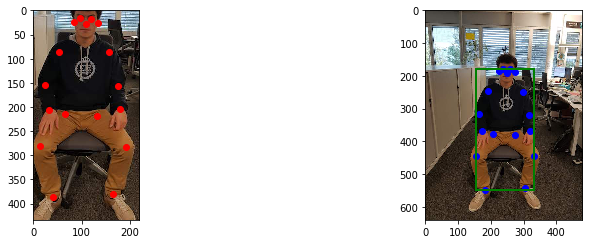

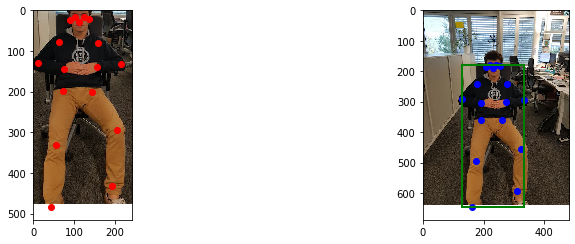

In [216]:
i,j = 0,7
vs.show_pp_on_image(pifpaf[i+2],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j+2],'./data/pifpaf/test_images/','.jpg')

In [208]:
go.Figure(vs.plot([preds_1[i],preds_1[j]]))

In [221]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv
def project_pose_2cam(pose, kk, z_shift, joints2keep):
    
    pose_moved = pose.copy()
    pose_moved[2] += z_shift
    projected_pose = []
    
    for point in pose_moved.transpose():
        projected_pose.append(list(project_to_pixels(point, kk)))
    
    projected_pose = np.array(projected_pose).transpose().astype(float)
    joints_indices = [pose2d.joint_dict[x] for x in joints2keep]
    shift = (projected_pose[:,pose2d.joint_dict['right hip']] + 
             projected_pose[:,pose2d.joint_dict['left hip']]).reshape((2,1))/2
    projected_pose[:,joints_indices] = pose2d.normalize(projected_pose[:,joints_indices], shift)
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, -10).transpose().flatten()

    return projected_pose

In [225]:
reproj_i = project_pose_2cam(preds_1[i].reshape((21,3)).transpose(), kk, depths[i], joints2keep)
reproj_j = project_pose_2cam(preds_1[j].reshape((21,3)).transpose(), kk, depths[j], joints2keep)

In [234]:
pose2d.joint_dict

{'nose': 0,
 'right shoulder': 1,
 'right elbow': 2,
 'right wrist': 3,
 'left shoulder': 4,
 'left elbow': 5,
 'left wrist': 6,
 'right hip': 7,
 'right knee': 8,
 'right ankle': 9,
 'left hip': 10,
 'left knee': 11,
 'left ankle': 12,
 'right eye': 13,
 'left eye': 14,
 'right ear': 15,
 'left ear': 16,
 'center shoulder': 17,
 'center hip': 18,
 'center back': 19,
 'head': 20}

In [237]:
upper_bod_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(20,17),(1,4),(1,2),(2,3),(4,5),(5,6),(17,19),
                    (19,18),(18,7),(18,10)]
go.Figure(vs.plot([ input_poses[i],reproj_i], upper_bod_co))

In [176]:
go.Figure(vs.plot(preds_1[5::2]))

##### actor 2

In [186]:
preds_2 = []

for i in range(2):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_2.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_2.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
    print(d_pred)
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_2.append(pred_pose)
    

1.2063386
1.3261288


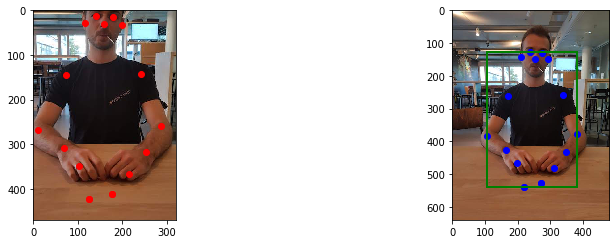

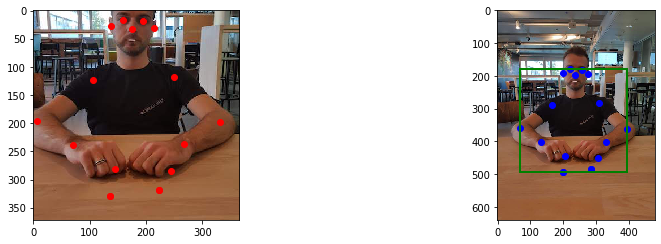

In [187]:
i,j = 0,1
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j],'./data/pifpaf/test_images/','.jpg')

In [188]:
go.Figure(vs.plot([base_3d_pose, preds_2[i],preds_2[j]]))